In [8]:
#Unzip folder with helpers
! unzip -q /content/dataiku_assignment-main.zip 

In [9]:
#Change path
%cd /content/dataiku_assignment-main

/content/dataiku_assignment-main


In [10]:
#Install new libraries
!pip install scikit-optimize --q

In [39]:
#Import all the modules
import json
import time

#Logistic 
import warnings
warnings.filterwarnings('ignore') #dangerous, applied once all the code has been debugged

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from math import sqrt
from scipy.stats import (wilcoxon,
                         ks_2samp)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (cohen_kappa_score,
                             confusion_matrix,
                             f1_score,
                             mean_absolute_error,
                             mean_squared_error,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (cross_val_score,
                                     StratifiedKFold)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler)
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

# Local module imports
from src.preprocessing import encode_column
from engine.best_model import evaluate_classifiers
from engine.optimisation import (get_best_params_for_random_forest,
                                 calibrate_random_forest)

#Open column mapping JSON file
with open('/content/dataiku_assignment-main/json_files/data_cols.json', 'r') as openfile:
  cols = json.load(openfile)

In [12]:
#Read task dataframes
train=pd.read_csv("/content/drive/MyDrive/census_income_learn.csv",header=None,names=cols.keys())
test=pd.read_csv("/content/drive/MyDrive/census_income_test.csv",header=None,names=cols.keys())
train.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [13]:
# Delete instance_weight as advised in the original documentation.
train.drop(columns='instance_weight',inplace=True)
test.drop(columns='instance_weight',inplace=True)

In [14]:
print(train.target.value_counts())
print(test.target.value_counts())

 - 50000.    187141
 50000+.      12382
Name: target, dtype: int64
 - 50000.    93576
 50000+.      6186
Name: target, dtype: int64


##Exploratory Data Analysis

Checking the dimensions of a dataframe, null values and data type

In [15]:
# Examine the size and structure of the dataset
print(train.shape)
print(train.info())

(199523, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         199523 non-null  int64 
 1   class_of_worker                             199523 non-null  object
 2   detailed_industry_recode                    199523 non-null  int64 
 3   detailed_occupation_recode                  199523 non-null  int64 
 4   education                                   199523 non-null  object
 5   wage_per_hour                               199523 non-null  int64 
 6   enroll_in_edu_inst_last_wk                  199523 non-null  object
 7   marital_stat                                199523 non-null  object
 8   major_industry_code                         199523 non-null  object
 9   major_occupation_code                       199523 non-null  object


In machine learning, it is often necessary to encode categorical variables as numerical values in order to use them in models. This is because most machine learning algorithms only accept numerical input.

LabelEncoder works by assigning a unique integer to each category in a categorical variable. For example, if we have a categorical variable with three categories: "red", "green", and "blue", LabelEncoder would assign 0 to "red", 1 to "green", and 2 to "blue". This allows us to use the categorical variable in machine learning algorithms that only accept numerical input.

In [16]:
# Taking all variables to numeric data type
# Call LabelEncoder object 
le = LabelEncoder()
# Encode the columns of the train and test DataFrames using the LabelEncoder object
train = train.apply(encode_column, le=le)
test = test.apply(encode_column, le=le)
# Split data into features (X) and target (y)
X_train = train.drop(columns="target")
y_train = train["target"]

Computing pairwise correlations (corrwith()) is a statistical technique that helps to understand the relationships between different variables and the target in a dataset,and uncover these potential relations of interest. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


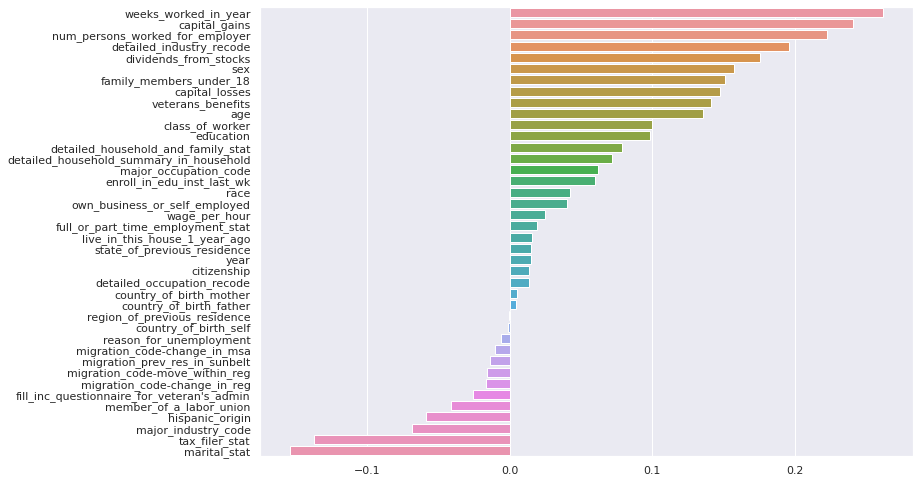

In [17]:
# Calculate correlations between columns in train and target 
corr = train.corrwith(train["target"])
# Sort the correlations in descending order
corr.sort_values(ascending=False, inplace=True)
# Extract the index (i.e., column names) and values from the sorted correlations
y = corr.index
x = corr.values
# Create a bar plot with the sorted correlations, excluding the first value (which is the target column)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x[1:], y[1:])

A correlation heatmap is a graphical representation of the strength and direction of the correlation between pairs of variables in a dataset. It allows for easy visualization of the relationships between variables and can be useful for identifying patterns, trends, and relationships in the data. It can also help identify strongly and weakly correlated variables, which can be useful for selecting variables to include in a model or identifying variables that may not be useful for a particular analysis or modeling task. Here we mark with a star the variable with a really strong correlation (0.75+). More star they have and more correlation these variables have.

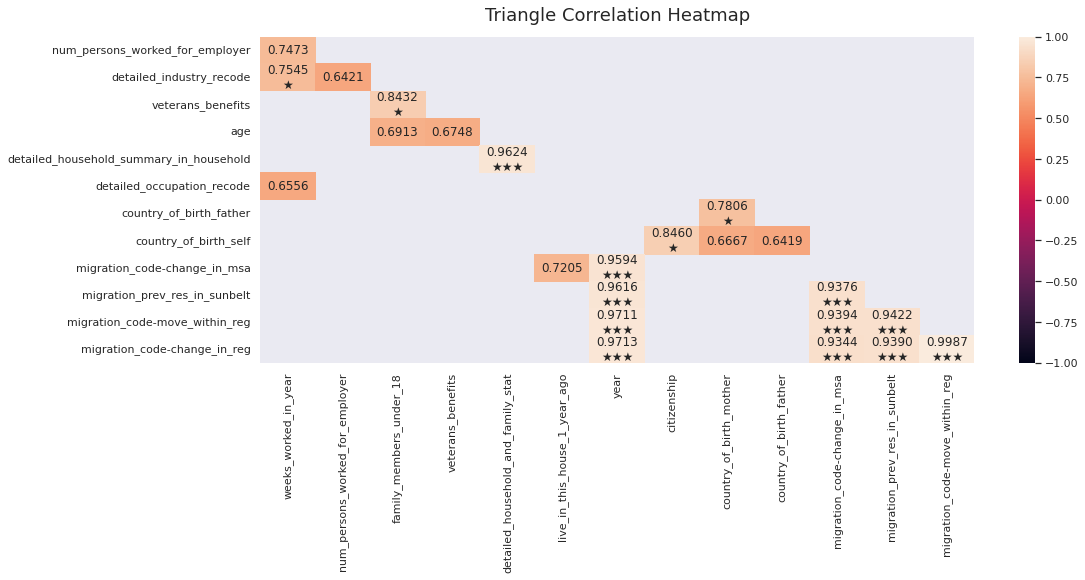

In [18]:
# Calculate correlations between columns in train and target 
#(NB: Correlation does not mean causation)
corr = train[y[1:]].corr().abs()

# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set the cut-off, extreme, and empty row/column thresholds
cut_off = 0.6  
extreme_1 = 0.75  
extreme_2 = 0.85  
extreme_3 = 0.90  

# Mask values below the cut-off threshold and flatten the resulting DataFrame
mask |= np.abs(corr) < cut_off
corr = corr[~mask]  

# Remove empty rows and columns if specified
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    # Find the non-empty rows and columns
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    # Select only the non-empty rows and columns from the correlation matrix
    corr = corr.iloc[wanted_cols, wanted_rows]

# Generate a list of annotated values for the heatmap
annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]

# Generate the heatmap
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)

# Show the plot
plt.show()


Is important to check for class imbalance in a dataset because it can negatively impact the performance of a  classification tasks. Class imbalance occurs when one class is significantly more or less represented than the other. If not addressed, class imbalance can lead to a model that is biased towards the majority class, has poor generalization performance, or is overfit to the majority class. It is important to check for class imbalance and address it using techniques such as undersampling, or oversampling to ensure that the model can accurately predict both classes and has good generalization performance.

0    187141
1     12382
Name: target, dtype: int64


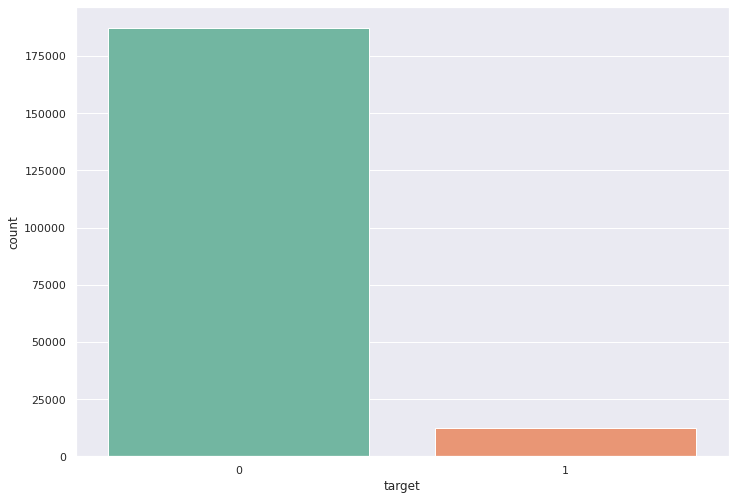

In [19]:
# Check for imbalanced classes in the target
target_counts = train['target'].value_counts()
print(target_counts)

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Generate the countplot
sns.set(style="darkgrid")
sns.countplot(x='target', data=train, ax=ax, palette="Set2")

# Show the plot
plt.show()

##Data preprocessing

###Data Resampling

###Finding more suited resampling technique

SMOTE and NearMiss are techniques used to address class imbalance in a dataset. SMOTE is an oversampling technique that generates synthetic minority class data points to balance the class distribution, while NearMiss is an undersampling technique that selects a subset of majority class data points to balance the class distribution.

In [ ]:
# Define the oversampling and undersampling techniques
smote = SMOTE(sampling_strategy='auto')
near_miss = NearMiss(sampling_strategy='auto')

# Perform oversampling and undersampling
start = time.time()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
time_smote = time.time() - start
start = time.time()
X_near_miss, y_near_miss = near_miss.fit_resample(X_train, y_train)
time_near_miss = time.time() - start
# Define a model
model = LogisticRegression(solver='lbfgs', max_iter=100)

# Calculate cross-validated scores and execution times for the original, oversampled, and undersampled data

scores_orig = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
scores_smote = cross_val_score(model, X_smote, y_smote, cv=5, scoring='f1')
scores_near_miss = cross_val_score(model, X_near_miss, y_near_miss, cv=5, scoring='f1')


In [21]:
#Print performances
print(f"Original data: mean F1 score={scores_orig.mean():.3f}, std={scores_orig.std():.3f}, time={0:.3f} seconds")
print(f"SMOTE data: mean F1 score={scores_smote.mean():.3f}, std={scores_smote.std():.3f}, time={time_smote:.3f} seconds")
print(f"NearMiss data: mean F1 score={scores_near_miss.mean():.3f}, std={scores_near_miss.std():.3f}, time={time_near_miss:.3f} seconds")

Original data: mean F1 score=0.322, std=0.008, time=0.000 seconds
SMOTE data: mean F1 score=0.840, std=0.002, time=6.611 seconds
NearMiss data: mean F1 score=0.841, std=0.015, time=70.470 seconds


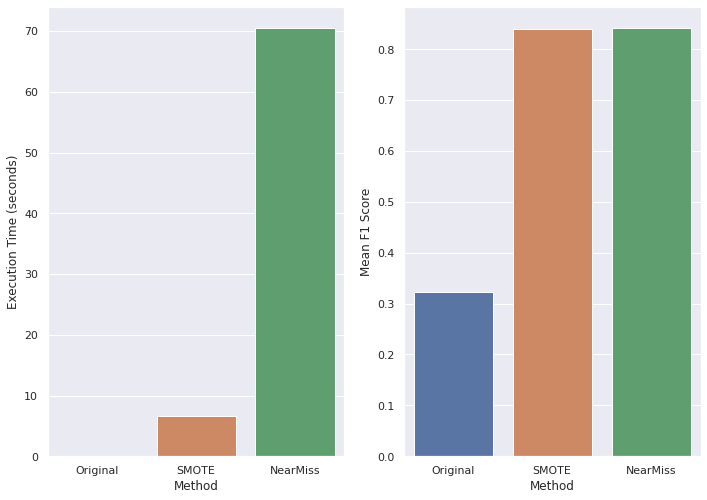

In [22]:
# Creating a dataframe with the mean cross-validated scores and execution times
data = {
    'Method': ['Original', 'SMOTE', 'NearMiss'],
    'Mean F1 Score': [scores_orig.mean(), scores_smote.mean(), scores_near_miss.mean()],
    'Execution Time (seconds)': [ 0,time_smote, time_near_miss]
}
df = pd.DataFrame(data)

fig, ax =plt.subplots(1,2)
sns.barplot(x='Method', y='Execution Time (seconds)', data=df, ax=ax[0])
sns.barplot(x='Method', y='Mean F1 Score', data=df, ax=ax[1])
fig.show()

In [23]:
#Resample dataframe
#Choosing SMOTE()
rus=SMOTE()
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test = test.drop(columns="target")
y_test = test["target"]

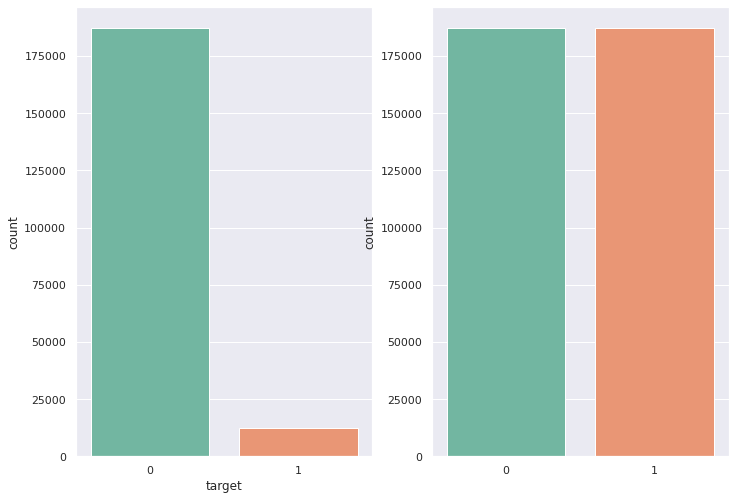

In [24]:
#Compare target variable before and after resampling
fig, ax =plt.subplots(1,2)
sns.countplot(x='target', data=train, ax=ax[0], palette="Set2")
sns.countplot(x=y_train.values, ax=ax[1], palette="Set2")
fig.show()

### Dimensionality reduction

Principal component analysis (PCA) is a technique that reduces the dimensionality of a dataset while retaining as much information as possible. It is often used in data preprocessing to simplify the dataset and make it easier to work with. PCA can reduce computational costs, remove redundancy in the data, and improve the performance of machine learning models by reducing the risk of overfitting.
The plot below demonstrates the use of the elbow method to determine the optimal number of principal components, using a threshold of 0.75.

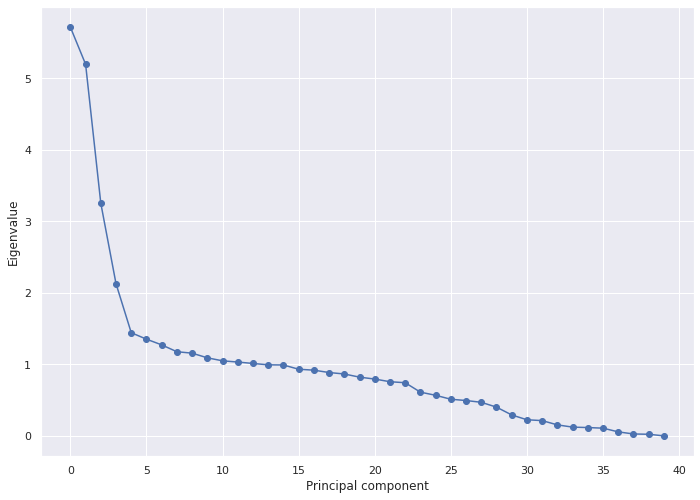

Number of components:  22


In [25]:
#Perform PCA

# Standardize the data
X = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

# Create the PCA object
pca = PCA()

# Fit the PCA to the data and transform the data onto the new, lower-dimensional space
X_transformed = pca.fit_transform(X)

# Get the eigenvalues of the principal components
eigenvalues = pca.explained_variance_

# Plot the eigenvalues in decreasing order
plt.plot(np.arange(len(eigenvalues)), eigenvalues, 'o-')
plt.xlabel("Principal component")
plt.ylabel("Eigenvalue")
plt.show()

# Determine the number of components to retain based on the "elbow" in the plot
n_components = 0
for i, val in enumerate(eigenvalues):
    if val < 0.75:
        n_components = i
        break

print("Number of components: ", n_components)

### Define a base model (logistic Regression) Compare naive model, PCA and optimised variants.

Stratified k-fold cross-validation is a technique for evaluating the performance of a machine learning model. It involves dividing the dataset into k folds, where k is a user-specified number, and training the model on k-1 folds and evaluating it on the remaining fold. This process is repeated k times, with a different fold used as the evaluation set each time.

Stratified k-fold cross-validation is called "stratified" because it ensures that the proportions of different classes in the folds are approximately the same as in the original dataset. This is particularly important when the class distribution is imbalanced, as it can help ensure that the model is evaluated on a representative sample of the data.

For example, if you have a binary classification dataset with a class distribution of 60% positive and 40% negative, and you perform 5-fold stratified cross-validation, each fold will contain approximately 60% positive and 40% negative examples. This is in contrast to regular k-fold cross-validation, which does not guarantee that the class distribution is preserved in each fold.

In [26]:
#Define cv method
skf=StratifiedKFold(n_splits=5)

Logistic regression is a statistical model used for binary classification. It estimates the probability that an input belongs to a certain class, and predicts the class with the highest probability.


In [27]:
# Create the logistic regression classifier
clf = LogisticRegression(solver='lbfgs', max_iter=100)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Calculate and print the F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 score (base model): {f1:.3f}")





F1 score (base model): 0.357


Bayesian optimization is often used in machine learning to optimize hyperparameters, which are parameters that are not learned from the data but are set by the user.


In [28]:
# Define the parameter search space
param_space = {
    'C': (0.001, 100)
}

# Create the Bayesian optimization object
opt = BayesSearchCV(clf, param_space, cv=skf, n_iter=10)

# Fit the optimization object to the training data
opt.fit(X_train, y_train)

# Get the best estimator
best_clf = opt.best_estimator_

# Calculate and print the F1 score on the test set using the best estimator
f1 = f1_score(y_test, best_clf.predict(X_test))
print(f"F1 score (best model): {f1:.3f}")


F1 score (best model): 0.357



Calibration is the process of adjusting the output of a model to better match the true values of the data. 

In [29]:
# Create a calibrated classifier using the best estimator
calibrated_clf = CalibratedClassifierCV(best_clf, cv=skf, method='sigmoid')

# Fit the calibrated classifier to the training data
calibrated_clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = calibrated_clf.predict(X_test)

# Calculate and print the F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 score (calibrated model): {f1:.3f}")

F1 score (calibrated model): 0.343


In [30]:
# Standardize the data using the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the PCA object
pca = PCA(n_components=n_components)

# Fit the PCA to the data and transform the data onto the new, lower-dimensional space
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_test_scaled = scaler.transform(X_test)

# Create the PCA object
pca = PCA(n_components=n_components)

# Fit the PCA to the data and transform the data onto the new, lower-dimensional space
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create the logistic regression classifier
clf_pca = LogisticRegression(solver='lbfgs', max_iter=100)

# Fit the classifier to the training data
clf_pca.fit(X_train_pca, y_train)

# Predict the labels of the test set
y_pred = clf_pca.predict(X_test_pca)

# Calculate the F1 score

f1 = f1_score(y_test, y_pred)
print(f"F1 score (base model): {f1:.3f}")
# Create the Bayesian optimization object
opt = BayesSearchCV(clf_pca, param_space, cv=skf, n_iter=10)

# Fit the optimization object to the training data
opt.fit(X_train_pca, y_train)

# Fit the optimization object to the training data
best_clf = opt.best_estimator_

# Calculate the F1 score
f1 = f1_score(y_test, best_clf.predict(X_test_pca))
print(f"F1 score (best model): {f1:.3f}")

# Fit the calibrated classifier to the training data
calibrated_clf_pca = CalibratedClassifierCV(best_clf, cv=skf, method='sigmoid')

# Create a calibrated classifier using the best estimator
calibrated_clf_pca.fit(X_train_pca, y_train)

# Predict the labels of the test set
y_pred = calibrated_clf_pca.predict(X_test_pca)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 score (calibrated model): {f1:.3f}")


F1 score (base model): 0.352
F1 score (best model): 0.352
F1 score (calibrated model): 0.344


A calibration curve is a plot that shows the relationship between the predicted probabilities of a classification model and the true class labels.

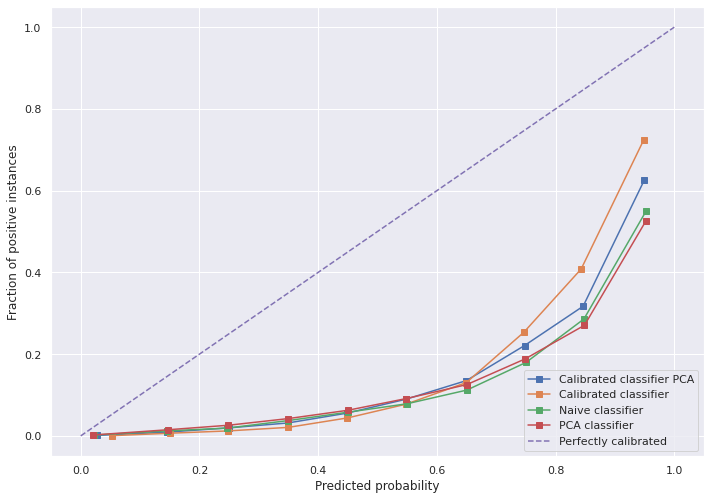

In [31]:
# Get predicted probabilities for the positive class for each classifier
y_pred_proba_calibrated_pca = calibrated_clf_pca.predict_proba(X_test_pca)[:, 1]
y_pred_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]
y_pred_proba_naive = clf.predict_proba(X_test)[:, 1]
y_pred_proba_pca = clf_pca.predict_proba(X_test_pca)[:, 1]

# Calculate fraction of positive instances and mean predicted value for calibrated classifier on PCA-transformed data
fraction_of_positives_calibrated_pca, mean_predicted_value_calibrated_pca = calibration_curve(y_test, y_pred_proba_calibrated_pca, n_bins=10)

# Calculate fraction of positive instances and mean predicted value for calibrated classifier on original data
fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

# Calculate fraction of positive instances and mean predicted value for naive classifier on original data
fraction_of_positives_naive, mean_predicted_value_naive = calibration_curve(y_test, y_pred_proba_naive, n_bins=10)

# Calculate fraction of positive instances and mean predicted value for classifier on PCA-transformed data
fraction_of_positives_pca, mean_predicted_value_pca = calibration_curve(y_test, y_pred_proba_pca, n_bins=10)

# Plot calibration curves for each classifier
plt.plot(mean_predicted_value_calibrated_pca, fraction_of_positives_calibrated_pca, 's-', label="Calibrated classifier PCA")
plt.plot(mean_predicted_value_calibrated, fraction_of_positives_calibrated, 's-', label="Calibrated classifier")
plt.plot(mean_predicted_value_naive, fraction_of_positives_naive, 's-', label="Naive classifier")
plt.plot(mean_predicted_value_pca, fraction_of_positives_pca, 's-', label="PCA classifier")
plt.plot([0, 1], [0, 1], '--', label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positive instances")
plt.legend(loc="lower right")
plt.show()

A receiver operating characteristic (ROC) curve is a plot that shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) of a classification model. It is used with the area under the curve (AUC) to evaluate the performance of a model on a binary classification task. The ROC curve is a useful tool for visualizing the performance of a model and understanding how it is making decisions, and the AUC is a measure of the model's overall performance.


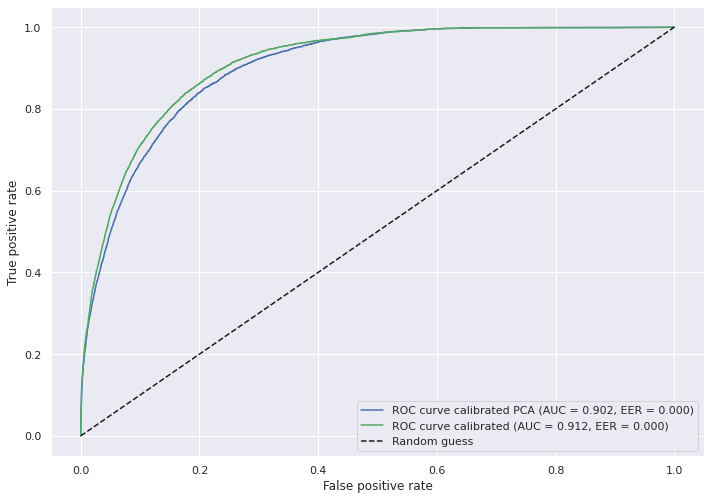

In [32]:
# Calculate the false positive rate and true positive rate for each classifier
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba_calibrated_pca)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_proba_calibrated)

# Calculate the AUC for each classifier
auc1 = roc_auc_score(y_test, y_pred_proba_calibrated_pca)
auc2 = roc_auc_score(y_test, y_pred_proba_calibrated)

# Calculate the difference in AUC
auc_diff = auc1 - auc2

# Find the EER for each classifier
eer1 = fpr1[np.abs(fpr1 - tpr1).argmin()]
eer2 = fpr2[np.abs(fpr2 - tpr2).argmin()]

# Plot the ROC curves
plt.plot(fpr1, tpr1, 'b-', label='ROC curve calibrated PCA (AUC = {:.3f}, EER = {:.3f})'.format(auc1, eer1))
plt.plot(fpr2, tpr2, 'g-', label='ROC curve calibrated (AUC = {:.3f}, EER = {:.3f})'.format(auc2, eer2))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

A confusion matrix allows us to see how well a model is performing on a classification task by showing the number of true positive, true negative, false positive, and false negative predictions. This can help understand the strengths and weaknesses of a model and identify any problems with the model's performance.



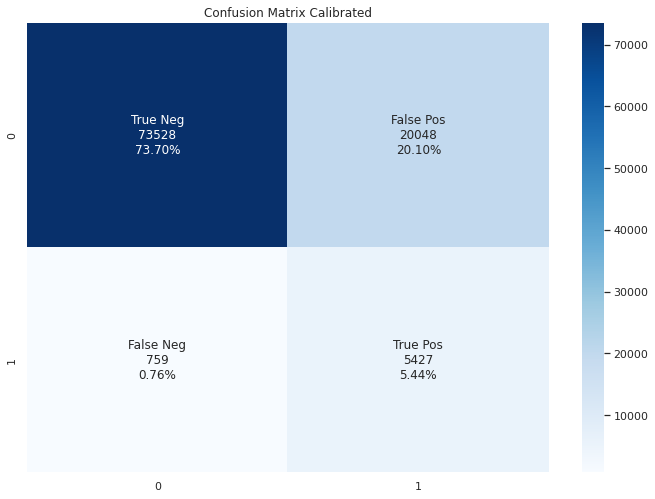

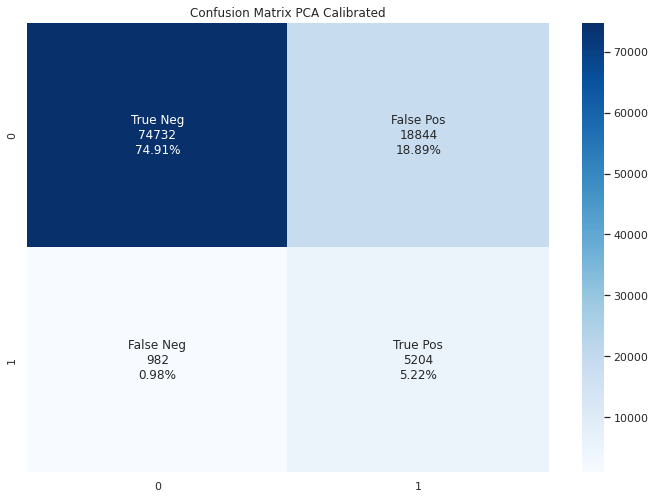

In [33]:
# Plot confusion matrix

cf_matrix=confusion_matrix(y_test, calibrated_clf.predict(X_test))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix Calibrated')
plt.show()

cf_matrix=confusion_matrix(y_test, calibrated_clf_pca.predict(X_test_pca))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix PCA Calibrated')
plt.show()

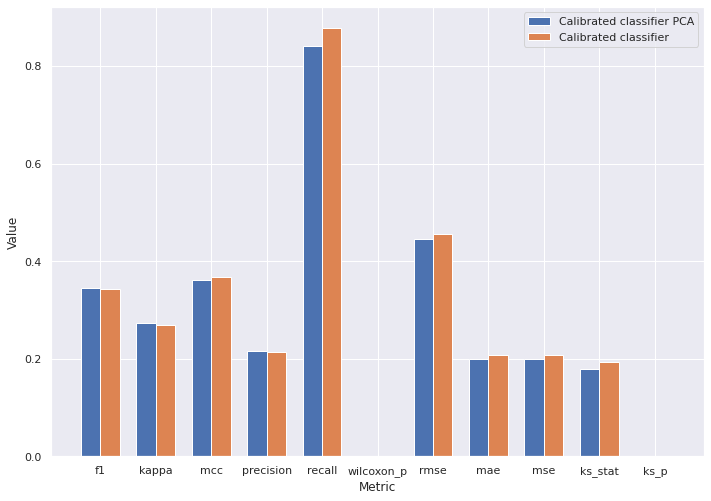

Evaluation metrics for calibrated classifier PCA:
{'f1': 0.3442481973936628, 'kappa': 0.27248531341165994, 'mcc': 0.3607919296047456, 'precision': 0.21640053226879574, 'recall': 0.8412544455221468, 'wilcoxon_p': 0.0, 'rmse': 0.44579477846102844, 'mae': 0.1987329845031174, 'mse': 0.1987329845031174, 'ks_stat': 0.17904612978889767, 'ks_p': 0.0}
Evaluation metrics for calibrated classifier
{'f1': 0.34281924133792363, 'kappa': 0.2699737260126044, 'mcc': 0.3667135231306452, 'precision': 0.2130323846908734, 'recall': 0.8773035887487876, 'wilcoxon_p': 0.0, 'rmse': 0.4566906918292163, 'mae': 0.2085663880034482, 'mse': 0.2085663880034482, 'ks_stat': 0.19335017341272231, 'ks_p': 0.0}


In [40]:
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    wilcoxon_stat, wilcoxon_p = wilcoxon(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    ks_stat, ks_p = ks_2samp(y_test, y_pred)
    return {'f1': f1, 'kappa': kappa, 'mcc': mcc, 'precision': precision, 'recall': recall,
             'wilcoxon_p':wilcoxon_p,'rmse':rmse,
            'mae':mae,'mse':mse,'ks_stat':ks_stat, 'ks_p':ks_p}


# Calculate evaluation metrics for calibrated classifier PCA
eval_calibrated_pca = evaluate_classifier(calibrated_clf_pca,X_test_pca, y_test)

# Calculate evaluation metrics for calibrated classifier
eval_calibrated = evaluate_classifier(calibrated_clf,X_test, y_test)


# Print results
metrics = list(eval_calibrated_pca.keys())
values_1 = list(eval_calibrated_pca.values())
values_2 = list(eval_calibrated.values())


bar_width = 0.35


r1 = np.arange(len(values_1))
r2 = [x + bar_width for x in r1]

plt.bar(r1, values_1, width=bar_width, label='Calibrated classifier PCA')
plt.bar(r2, values_2, width=bar_width, label='Calibrated classifier')


plt.xticks([r + bar_width/2 for r in range(len(values_1))], metrics)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend()


plt.show()



print("Evaluation metrics for calibrated classifier PCA:")
print(eval_calibrated_pca)

print("Evaluation metrics for calibrated classifier")
print(eval_calibrated)




Check if PCA and naive model have the same distribution

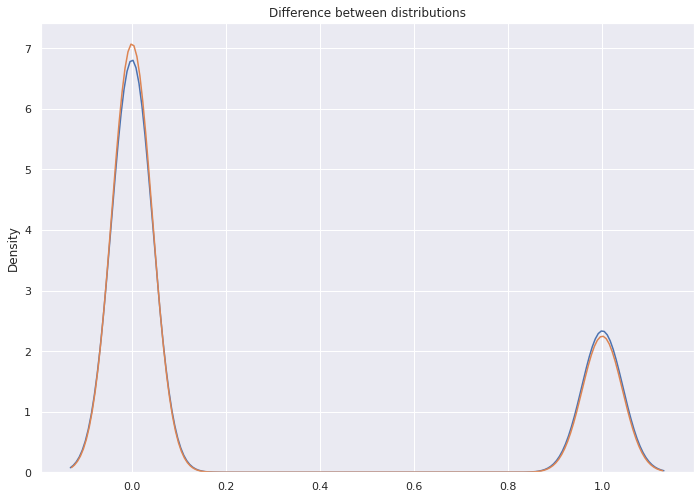

In [41]:
y_pred=calibrated_clf.predict(X_test)
y_pred_pca=calibrated_clf_pca.predict(X_test_pca)

# Visualize the difference between distributions using a density plot

sns.kdeplot(y_pred,label='Calibrated')
sns.kdeplot(y_pred_pca,label='Calibrated with PCA')
plt.title('Difference between distributions',)

plt.show()

##Training

**RandomForestClassifier**: Random forest is a type of ensemble learning method that is used for classification and regression tasks. It involves training multiple decision trees on a dataset and then combining the predictions of the individual trees to make a final prediction. The decision trees in a random forest are trained using a random subset of the features in the dataset, which helps to reduce the risk of overfitting and improve the model's generalization performance.

**GradientBoostingClassifie**r: Gradient boosting is another type of ensemble learning method that is used for classification and regression tasks. It involves training a series of decision trees on a dataset, where each tree is trained to correct the errors made by the previous tree. The final prediction is made by combining the predictions of the individual trees. Gradient boosting is a powerful method that can achieve good performance on a wide range of tasks, but it can be sensitive to overfitting and may require careful tuning of the model parameters.

**DecisionTreeClassifier**: Decision tree is a type of supervised learning algorithm that is used for classification and regression tasks. It works by creating a tree-like model of decisions based on the features of a dataset. Each internal node of the tree represents a decision based on the value of a feature, and each leaf node represents a prediction. Decision tree is a simple and interpretable model, but it can be prone to overfitting and may not perform well on complex tasks.

In [42]:
#add loga regression
#naive bayes

classifiers = [
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        DecisionTreeClassifier()
    ]
# Evaluate the classifiers using the evaluate_classifiers function
results = evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test)

# Print the results for each classifier

for result in results:
        print(
            f"{result['classifier']}:"
            f" Recall = {result['recall']:.3f},"
            f" Precision = {result['precision']:.3f}"
            f" F1 = {result['f1']:.3f},"
            f" ROC AUC = {result['roc_auc']:.3f},"
            f" Wilcoxon Stat = {result['wilcoxon_stat']:.3f},"
            f" Wilcoxon p-value = {result['wilcoxon_pvalue']:.3f},"
            f" Train Time = {result['train_time']:.3f}s,"
            f" Eval Time = {result['eval_time']:.3f}s")


RandomForestClassifier: Recall = 0.610, Precision = 0.480 F1 = 0.537, ROC AUC = 0.783, Wilcoxon Stat = 7858410.000, Wilcoxon p-value = 0.000, Train Time = 79.158s, Eval Time = 3.474s
GradientBoostingClassifier: Recall = 0.802, Precision = 0.330 F1 = 0.468, ROC AUC = 0.847, Wilcoxon Stat = 6908387.500, Wilcoxon p-value = 0.000, Train Time = 110.292s, Eval Time = 0.274s
DecisionTreeClassifier: Recall = 0.551, Precision = 0.304 F1 = 0.391, ROC AUC = 0.734, Wilcoxon Stat = 14716711.500, Wilcoxon p-value = 0.000, Train Time = 5.936s, Eval Time = 0.042s


##Evaluation

In [43]:
results

[{'classifier': 'RandomForestClassifier',
  'recall': 0.6096023278370514,
  'precision': 0.47958794353300266,
  'f1': 0.5368353619474695,
  'roc_auc': 0.7829365832568176,
  'wilcoxon_stat': 7858410.0,
  'wilcoxon_pvalue': 5.394368721322222e-96,
  'train_time': 79.15808701515198,
  'eval_time': 3.47446346282959},
 {'classifier': 'GradientBoostingClassifier',
  'recall': 0.8019721952796638,
  'precision': 0.33042493672572265,
  'f1': 0.46801886792452824,
  'roc_auc': 0.8472704013074389,
  'wilcoxon_stat': 6908387.5,
  'wilcoxon_pvalue': 0.0,
  'train_time': 110.29209494590759,
  'eval_time': 0.27422642707824707},
 {'classifier': 'DecisionTreeClassifier',
  'recall': 0.5510830908503072,
  'precision': 0.3035618878005343,
  'f1': 0.3914790996784566,
  'roc_auc': 0.733751983999147,
  'wilcoxon_stat': 14716711.5,
  'wilcoxon_pvalue': 0.0,
  'train_time': 5.9359540939331055,
  'eval_time': 0.04193115234375}]

F1 score is a weighted average of precision and recall. As we know in precision and in recall there is false positive and false negative so it also consider both of them. F1 score is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.


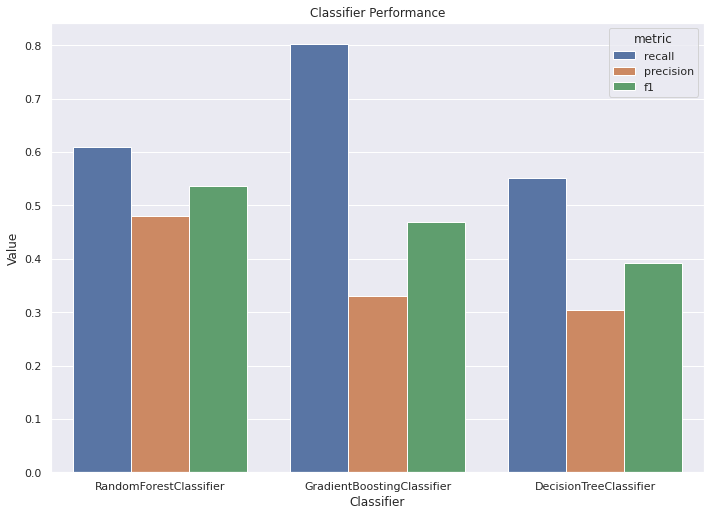

In [44]:
# Rename variable
data=results
# Extract the data into separate lists
classifiers = [x['classifier'] for x in data]
recall = [x['recall'] for x in data]
precision = [x['precision'] for x in data]
f1 = [x['f1'] for x in data]

# Create a dataframe with the data
df = pd.DataFrame({
    'classifier': classifiers,
    'recall': recall,
    'precision': precision,
    'f1': f1
})

# Reshape the data into a long format
df_long = df.melt(id_vars=['classifier'], var_name='metric', value_name='value')

# Create the bar plot
sns.barplot(x='classifier', y='value', hue='metric', data=df_long)

# Add a title and labels
plt.title("Classifier Performance")
plt.xlabel("Classifier")
plt.ylabel("Value")

# Show the plot
plt.show()

In [45]:
#Get Accuracy as original proposed on the material provided (as a form of sanity check)
# Create a random forest classifier
clf_rf = RandomForestClassifier()
clf_boost = GradientBoostingClassifier()
# Fit the classifier to the training data
clf_rf.fit(X_train, y_train)
clf_boost.fit(X_train, y_train)
# Obtain the accuracy on the test data
accuracy_rf = clf_rf.score(X_test, y_test)
accuracy_boost = clf_boost.score(X_test, y_test)
print(f"Accuracy RF: {accuracy_rf:.2f}")
print(f"Accuracy GBoosting: {accuracy_boost:.2f}")

Accuracy RF: 0.93
Accuracy GBoosting: 0.89


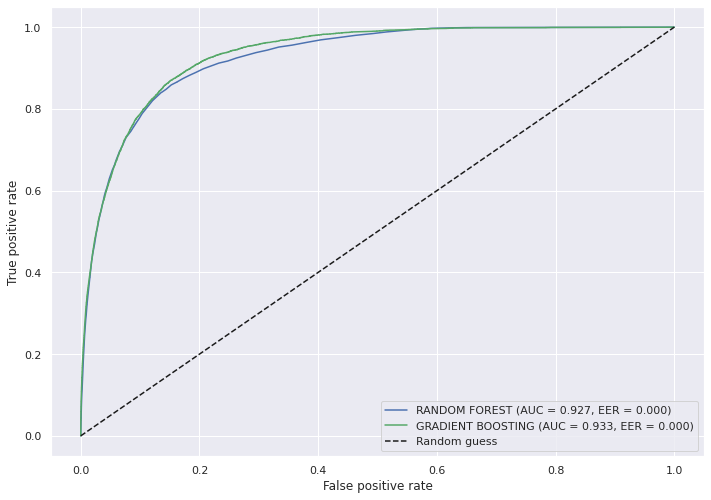

In [56]:
# Calculate the false positive rate and true positive rate for each classifier
fpr1, tpr1, thresholds1 = roc_curve(y_test, clf_rf.predict_proba(X_test)[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, clf_boost.predict_proba(X_test)[:, 1])

# Find the EER for each classifier
eer1 = fpr1[np.abs(fpr1 - tpr1).argmin()]
eer2 = fpr2[np.abs(fpr2 - tpr2).argmin()]

auc1= roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:, 1])
auc2= roc_auc_score(y_test, clf_boost.predict_proba(X_test)[:, 1])
# Plot the ROC curves
plt.plot(fpr1, tpr1, 'b-', label='RANDOM FOREST (AUC = {:.3f}, EER = {:.3f})'.format(auc1, eer1))
plt.plot(fpr2, tpr2, 'g-', label='GRADIENT BOOSTING (AUC = {:.3f}, EER = {:.3f})'.format(auc2, eer2))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

The future importance of a feature is a measure of how important the feature is for making predictions. 

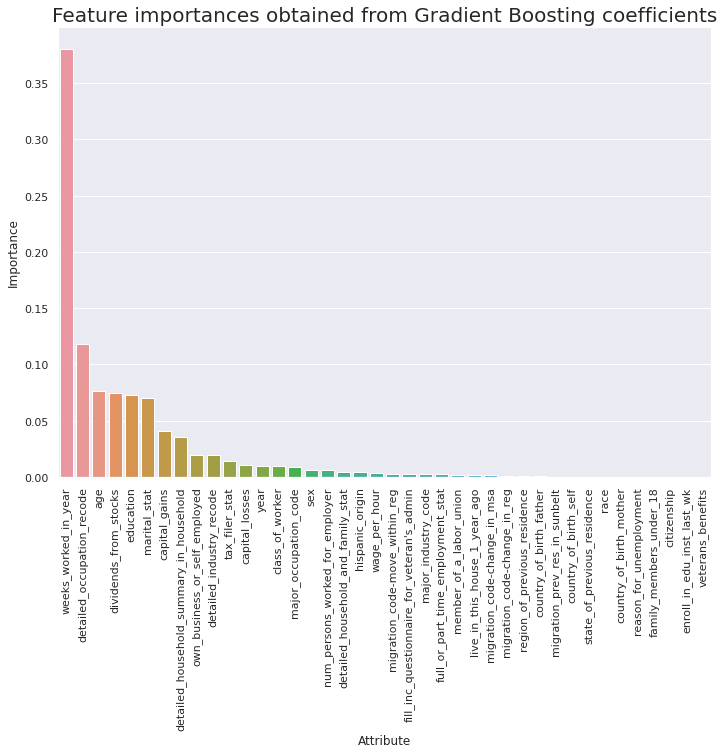

In [47]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': clf_boost.feature_importances_
})

importances = importances.sort_values(by='Importance', ascending=False)

sns.barplot(x='Attribute', y='Importance', data=importances)
plt.title('Feature importances obtained from Gradient Boosting coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

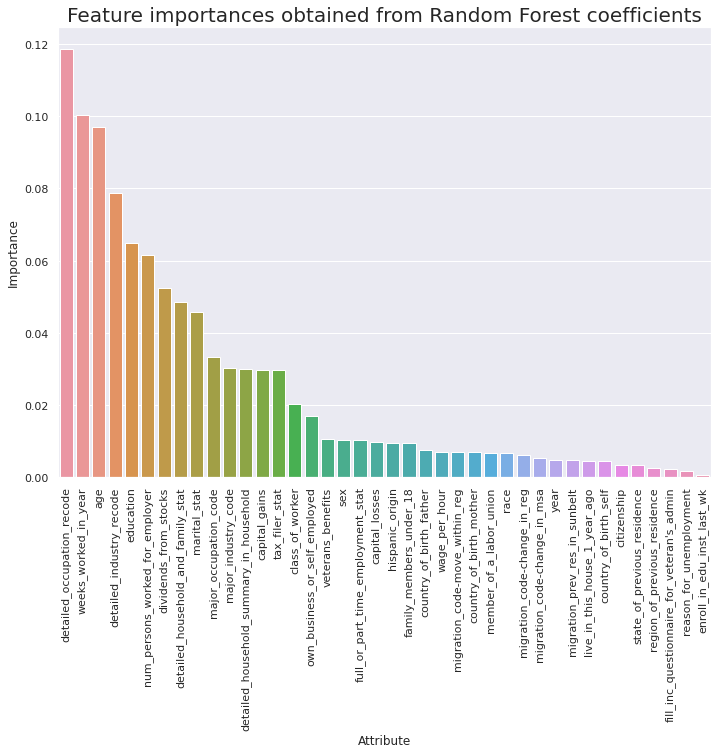

In [48]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': clf_rf.feature_importances_
})

importances = importances.sort_values(by='Importance', ascending=False)

sns.barplot(x='Attribute', y='Importance', data=importances)
plt.title('Feature importances obtained from Random Forest coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [49]:
# Fit the calibrated classifier to the training data
calibrated_clf_boost = CalibratedClassifierCV(clf_boost, cv=skf, method='sigmoid')
calibrated_clf_rf = CalibratedClassifierCV(clf_rf, cv=skf, method='sigmoid')
# Create a calibrated classifier using the best estimator
calibrated_clf_boost.fit(X_train, y_train)
calibrated_clf_rf.fit(X_train, y_train)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(),
                       cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False))

When the number of examples for the positive and negative classes in your data is significantly different, 
it is recommended to use the F1 score for evaluation. 
If the class balance is more balanced, you can use the ROC or AUC curve to evaluate the model's performance.

We use F1 as final metrics


In [50]:
# Predict the labels of the test set
y_pred_boost = calibrated_clf_boost.predict(X_test)
y_pred_rf = calibrated_clf_rf.predict(X_test)
# Calculate the F1 score
print(f"F1 score (calibrated Gradient Boosting): {f1_score(y_test, y_pred_boost):.3f}")
print(f"F1 score (calibrated Random Forest): {f1_score(y_test, y_pred_rf):.3f}")

F1 score (calibrated Gradient Boosting): 0.476
F1 score (calibrated Random Forest): 0.536


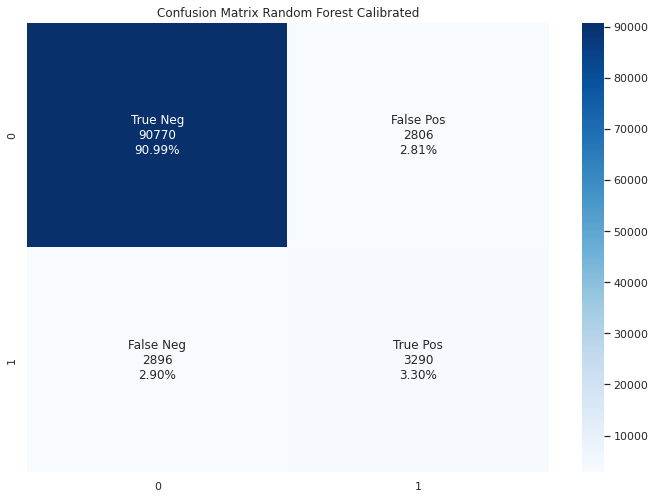

In [57]:
cf_matrix=confusion_matrix(y_test, calibrated_clf_rf.predict(X_test))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix Random Forest Calibrated')
plt.show()

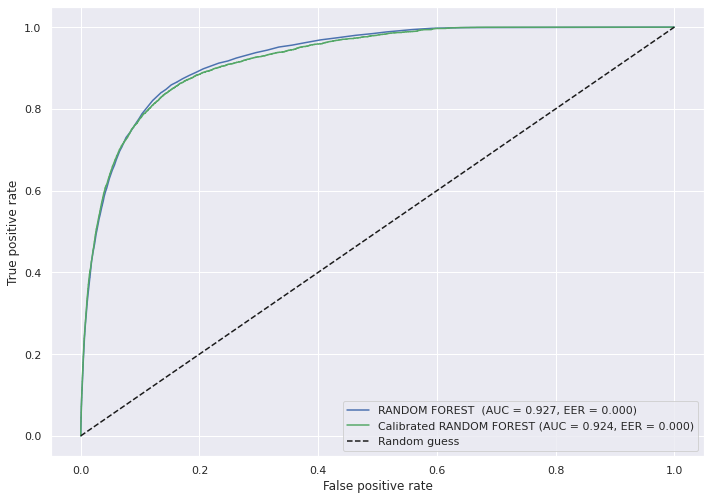

In [52]:
# Calculate the false positive rate and true positive rate for each classifier
fpr1, tpr1, thresholds1 = roc_curve(y_test, clf_rf.predict_proba(X_test)[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, calibrated_clf_rf.predict_proba(X_test)[:, 1])

# Find the EER for each classifier
eer1 = fpr1[np.abs(fpr1 - tpr1).argmin()]
eer2 = fpr2[np.abs(fpr2 - tpr2).argmin()]
auc1= roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:, 1])
auc2= roc_auc_score(y_test, calibrated_clf_rf.predict_proba(X_test)[:, 1])
# Plot the ROC curves
plt.plot(fpr1, tpr1, 'b-', label='RANDOM FOREST  (AUC = {:.3f}, EER = {:.3f})'.format(auc1, eer1))
plt.plot(fpr2, tpr2, 'g-', label='Calibrated RANDOM FOREST (AUC = {:.3f}, EER = {:.3f})'.format(auc2, eer2))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

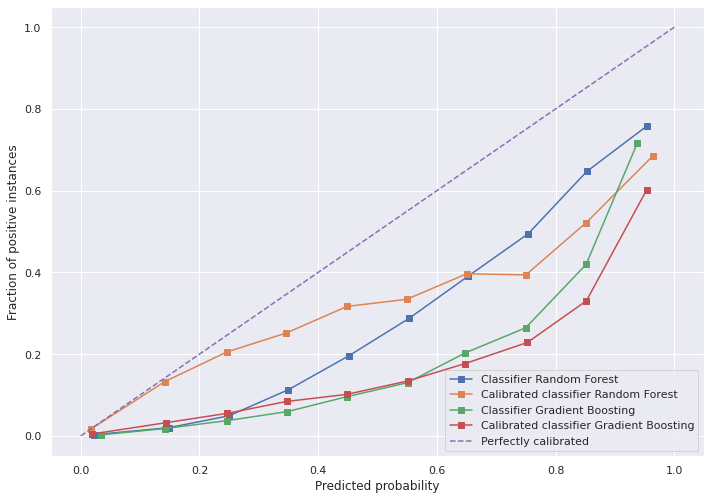

In [53]:
def plot_calibration_curve(y_test, y_pred_proba, label):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label=label)

# Get predicted probabilities for the positive class for each classifier
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_proba_calibrated_rf = calibrated_clf_rf.predict_proba(X_test)[:, 1]
y_pred_proba_boost = clf_boost.predict_proba(X_test)[:, 1]
y_pred_proba_calibrated_boost = calibrated_clf_boost.predict_proba(X_test)[:, 1]


plot_calibration_curve(y_test, y_pred_proba_rf, "Classifier Random Forest")
plot_calibration_curve(y_test, y_pred_proba_calibrated_rf, "Calibrated classifier Random Forest")
plot_calibration_curve(y_test, y_pred_proba_boost, "Classifier Gradient Boosting")
plot_calibration_curve(y_test, y_pred_proba_calibrated_boost, "Calibrated classifier Gradient Boosting")
plt.plot([0, 1], [0, 1], '--', label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positive instances")
plt.legend(loc="lower right")
plt.show()

To reinforce the best model decision (calibrated random forest) we use AAD, or average absolute deviation. It is a measure of the accuracy of a calibrated model. It is defined as the average absolute difference between the predicted probabilities of a classification model and the true class labels.

In [54]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, calibrated_clf_rf.predict_proba(X_test)[:, 1], n_bins=10)
aad = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
print (aad)

0.17101671225007264


In [55]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, clf_rf.predict_proba(X_test)[:, 1], n_bins=10)
aad = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
print (aad)

0.20298888452606131


##Conclusion

Although the naive Random Forest Model has a higher AUC score, it has a lower F1 score and AAD score compared to its calibrated versions. This suggests that the calibrated versions of the Random Forest Model is more accurate in terms of predicting the true class probabilities. In addition, both calibrated and uncalibrated versions of gradient boosting perform worse than the calibrated Random Forest Model in terms of F1 and AAD scores. This leads to the conclusion that the calibrated Random Forest Model is the best choice for this task, as it has the highest F1 and AAD scores.